# Single Crane as Part of a Gantry Crane: Derivation of Equations of Motion and Simulation

Strongly inspired by [Bolorkhuu Dariimaa](http://bolorkhuu.com/about.html) (2017), [Carsten Knoll](https://tu-dresden.de/ing/elektrotechnik/rst/das-institut/beschaeftigte/carsten-knoll) (2021), see [this](https://github.com/cknoll/demo-material/tree/main/underactuated_systems)

This notebook requires the python packages `ipydex` and `symbtools`. To install these, one might use:

```

!pip install ipydex symbtools

```

---


In [1]:
%load_ext ipydex.displaytools

from sympy import sin, cos, Function
import numpy as npy
np = npy
import sympy as sp
import sys
import pickle
import numpy as np
import symbtools as st
from symbtools import modeltools as mt
import pickle
np.set_printoptions(precision=3, suppress=True)

from matplotlib import pyplot as plt
import time
time.ctime()

'Wed Apr 13 10:22:09 2022'

In [2]:
from sympy.interactive import printing
printing.init_printing()

Image:

<img src="single_crane_diagram.svg">

In [3]:
t = sp.Symbol('t')
params = sp.symbols('m0, m1, l1, g, d0, d1')

st.make_global(params)

# TODO: System identification -> d0, d1
params_values = [(m0, 0.557), (m1, 0.1), (l1, 0.32), (g, 9.81),
                 (d0, 0.01), (d1, 0.01)]

F = sp.Symbol('F')

Np = 1 # number of passive coordinates (p = phi1)
Nq = 1 # number of actuated coordinates (q = x0)
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))

# all coordinates and their derivatives
ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)


---

---

---

Meaning of the variables: absolut values!

$[p_1, q_1] = [\varphi_1, x_0]$

---

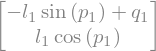

---

In [4]:
# Unit vectors in x-y-plane
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])
# Rotation matrix in x-y-plane
Rz = mt.Rz

# centers of masses -> S
# joints -> G

S0 = G0 = ex*q1 ##:

S1 = G1 =  G0 + Rz(p1)*ey*l1 ##:


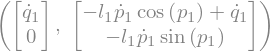

---

In [5]:
# Time derivatives of coordinates of the centers of masses
S0dt, S1dt = st.col_split(st.time_deriv(st.col_stack(S0, S1), ttheta)) ##:

In [6]:
# kinetic energy of the cart
T0 = 0.5 * m0 * qdot1**2
# kinetic energy of pendulum
T1 = 0.5 * m1 * (S1dt.T * S1dt)[0]

# total kinetic energy
T = T0 + T1

# total potential energy
V = g * m1 * (l1 - S1[1])

# viscous friction
# TODO: is this calculation correct?
R = 0.5 * d0 * qdot1**2 + 0.5 * d1 * pdot1**2

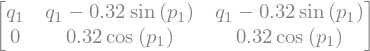

---

In [7]:
# joints and centers of mass for visualization
key_point_pos_expr = st.col_stack(G0, G1, S1).subs(params_values) ##:
key_point_pos_func = st.expr_to_func(ttheta, key_point_pos_expr, keep_shape=True)

### Visualization of kinematics (optional, just for didactic or debug purpose)

In [8]:
%matplotlib inline

def plot_func(p1, q1, lines=None, init=False):
    
    res_arr = key_point_pos_func(p1, q1)
    
    # joints
    xxg, yyg = res_arr[:, :2] 
    
    # centers of mass
    xxs, yys = res_arr[:, 2:]
    
    
    # G0, G1, S1 = res_arr.T    
    
    if lines is None:
        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-1.3,1.3))
        ax.set_aspect('equal')
        
        # plot joints and their connection
        line1, = ax.plot(xxg, yyg,"b-o")
        # plot mass m1
        line2, = ax.plot(xxs, yys,"r.")
        
        if init:
            return fig, ax, line1, line2

    else:
        line1, line2 = lines
        line1.set_data(xxg, yyg)
        line2.set_data(xxs, yys)
        
        return line1, line2

from ipywidgets import interact
@interact(p1=(np.pi/2, 3*np.pi/2, .05), q1=(-2, 2, .1))
def i_plot(p1, q1):
    plot_func(p1, q1)
    
    

interactive(children=(FloatSlider(value=3.1207963267948964, description='p1', max=4.71238898038469, min=1.5707…

In [10]:
# Force applied at ttheta
# TODO: Reibkräfte in Stellgröße einbauen
external_forces = [0, F] ##:

---

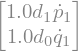

---

In [11]:
# Gradient of dissipative force R, no real purpose
st.gradient(R, tthetad).smplf.T ##:

In [12]:
if 1:
    with_dissipation = 1
    with_part_lin = 1
    # Calculate the model based on lagrange equation
    if with_dissipation == 1:
        %time mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, dissipation_function=R)
    else:
        mod = mt.generate_symbolic_model(T, V, ttheta, external_forces)
    
    if with_part_lin == 1:
        # What is exactly meant by this? -> Kollokierte partielle Linearisierung (2.3.1 Diss Knoll)
        # perform partial linearization such that system input is acceleration and not force
        mod.calc_coll_part_lin_state_eq()
    else:
        # Eingangsaffine Zustandsgleichungen xd = f(x)+g(x)*u
        mod.calc_state_eq()
    
    # write the model to disk to save time in the next run of the notebook
    with open("model_single_crane.pcl", "wb") as pfile:
        pickle.dump(mod, pfile)
else:
    with open("model_single_crane.pcl", "rb") as pfile:
        mod = pickle.load(pfile)

CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 1.07 s


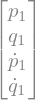

---

In [13]:
# states of the system
mod.xx ##:

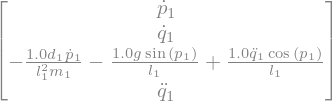

---

In [14]:
# State Space description / System of ODEs, rhs = f(x) + g(x)*u
if with_part_lin == 1:
    # u = q1dd after collocated partial linearization
    rhs = mod.ff + mod.gg*mod.aa ##:
else:
    # u = F
    rhs = mod.f + mod.g*F ##:

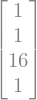

In [15]:
# count ops -> how big is the expression?
rhs.co

In [16]:
# equations of motions generate LaTeX-Code for the video:
from symbtools import interactive_aux as ia
ia.adapted_latex(mod.eqns)

\left(\begin{matrix}
1.0 d_{1} \dot{p}_{1} + 1.0 g l_{1} m_{1} \sin{\left(p_{1} \right)} + 1.0 l_{1}^{2} m_{1} \ddot{p}_{1} - 1.0 l_{1} m_{1} \ddot{q}_{1} \cos{\left(p_{1} \right)}\\
- F + 1.0 d_{0} \dot{q}_{1} + 1.0 m_{0} \ddot{q}_{1} + m_{1} \left(- l_{1} \ddot{p}_{1} \cos{\left(p_{1} \right)} + l_{1} \dot{p}_{1}^{2} \sin{\left(p_{1} \right)} + \ddot{q}_{1}\right)
\end{matrix}\right)
% -------------


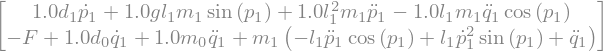

In [17]:
# set of Lagrange's ODEs describing the system
mod.eqns

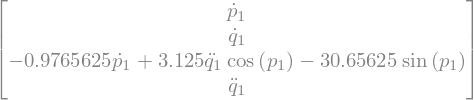

---

In [18]:
rhs_v = rhs.subs(params_values) ##:

In [19]:
# count_ops for each component (after substitution of numerical values)
rhs_v.co

In [20]:
# which symbols are still occurring?
rhs_v.s

In [21]:
# total energy:

Eges = T + V

In [22]:
if with_part_lin == 1:
    Edot = st.lie_deriv(Eges, mod.ff, mod.xx)
else:
    Edot = st.lie_deriv(Eges, mod.f, mod.xx)
    
Edot_conservative = Edot.subz0([d0, d1])

In [23]:
# conservative part of energy gradient
Edot_conservative.srn # only 0 if no energy conserving trafo (calc_state_eq() instead of calc_coll_part_lin_state_eq())

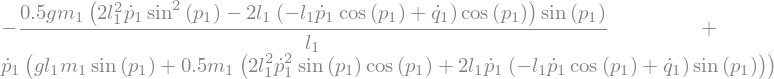

In [24]:
Edot_conservative

In [25]:
# plausibility check: Edot should be zero if qdot1 = 0.

Edot_test = Edot.subs(qdot1, 0)

# However the expresion is too large to be simplified in reasonable time
Edot_test.co ##:

# evaluate with `subs_random_numbers` and check that the expression is "zero up to numerical noise"
Edot_test.srn

---

## Create Simulation Model
(only for with_part_lin = 1)

In [26]:
simmod = st.SimulationModel(mod.ff, mod.gg, mod.xx, model_parameters=params_values)

In [27]:
def open_loop_angle_controller(t):
    if t < 0.5:
        return 1
    else:
        return 0

In [28]:
rhs = simmod.create_simfunction(input_function = open_loop_angle_controller)


In [29]:
xx0 = np.array([0.75*np.pi, 0, 0, 0])

In [30]:
from scipy.integrate import odeint

In [31]:
# simulate 5 seconds
tt = np.linspace(0, 15, 1000)
res = odeint(rhs, xx0, tt)  ##:S

---

In [32]:
Eges_subs = Eges.subs(params_values)
Eges_func = st.expr_to_func(mod.xx, Eges_subs)

In [33]:
Eges_subs.s ##:
mod.xx ##:T

---

---

In [34]:
# system energy at upper equilibrium
Eges_func(0, 0, 0, 0)

array(0.)

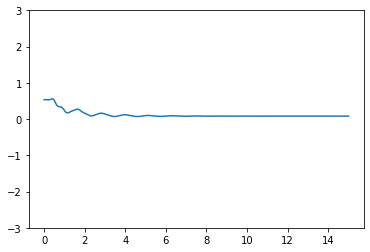

In [35]:
# check energy conservation

EE = Eges_func(*res[:, :].T)

plt.plot(tt, EE)
plt.ylim(-3, 3)


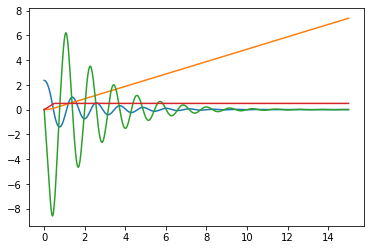

In [36]:
# plot state components 
# TODO: why are velocites = 0 all the time
plt.plot(tt, res)